In [55]:
import torch
import torchvision
import detectron2
from detectron2.utils.logger import setup_logger
import os
import numpy as np
import json
import cv2
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
import random
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
path = str(Path().absolute())
for d in ["train", "val", "test"]:
    DatasetCatalog.register("deer_" + d, lambda d=d: image_dicts(path + "/" +  d))
    MetadataCatalog.get("deer_" + d).set(thing_classes=["roe_deer", "deer_horns"])
deer_metadata = MetadataCatalog.get("deer_train")

In [3]:
def image_dicts(img_dir):
    classes = ["roe_deer", "deer_horns"]
    json_file = os.path.join(img_dir, "via_export_json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        try:
            record = {}
            filename = os.path.join(img_dir, v["filename"])
            height, width = cv2.imread(filename).shape[:2]

            record["file_name"] = filename
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            annos = v["regions"]
            objs = []
            for anno in annos:
                deer_class = anno['region_attributes'].get('roe_deer').rstrip("\n")
                if deer_class == 'roe_dee':
                    deer_class = 'roe_deer'
                anno = anno["shape_attributes"]
                px = anno["all_points_x"]
                py = anno["all_points_y"]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]
                obj = {
                    "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": classes.index(deer_class),
                    "iscrowd": 0,
                    }
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        except KeyError as e:
            print("Image missing")
        
    return dataset_dicts

In [4]:
train_dicts = image_dicts((path+'/train'))
valid_dicts = image_dicts((path+'/val'))
test_dicts = image_dicts((path+'/test'))

Image missing
Image missing
Image missing
Image missing
Image missing
Image missing
Image missing
Image missing
Image missing
Image missing
Image missing
Image missing


* Check random images

In [6]:
for d in random.sample(train_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("deer_train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2.imshow('images', vis.get_image()[:, :, ::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

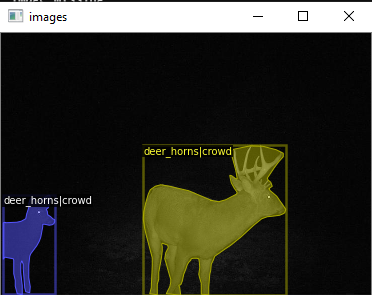

* Configure training

In [47]:
CUDA_VISIBLE_DEVICES = 0
cfg = get_cfg()
cfg.OUTPUT_DIR = path + '/output/'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("deer_train", ) 
cfg.DATASETS.TEST = ("deer_val", )
cfg.TEST.EVAL_PERIOD = 100 #evaluate validation
cfg.DATALOADER.NUM_WORKERS = 6  
cfg.SOLVER.IMS_PER_BATCH = 2   
cfg.SOLVER.BASE_LR = 0.00025    
cfg.SOLVER.MAX_ITER = 2000       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128    
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/22 22:31:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

* Test the model

In [48]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 
cfg.DATASETS.TEST = ("deer_test")
predictor = DefaultPredictor(cfg)

* Test dicts

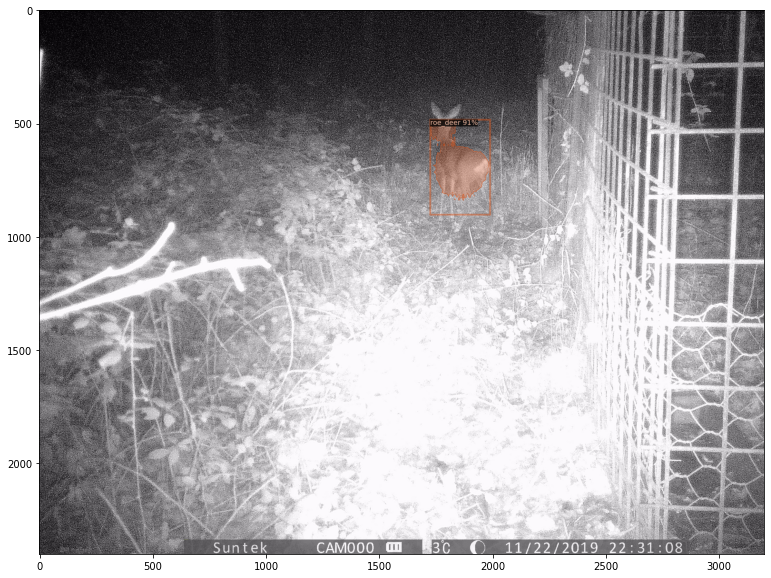

In [49]:
for d in random.sample(test_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=deer_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

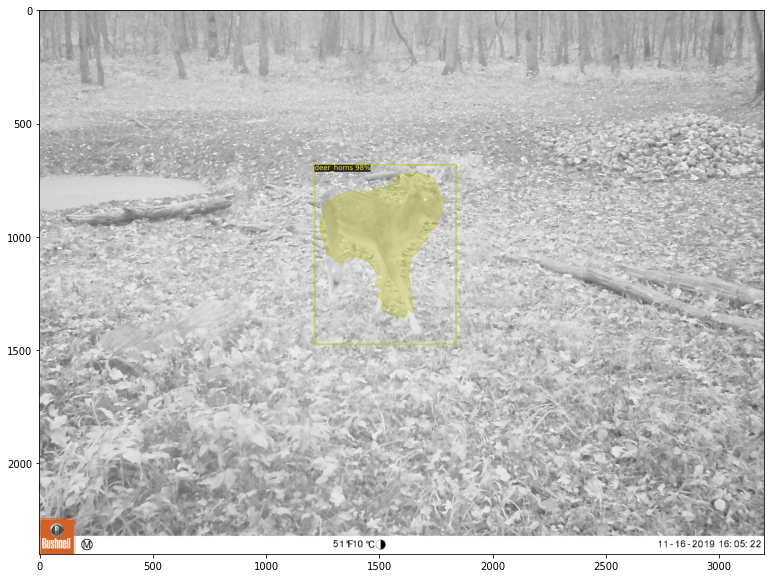

In [50]:
for d in random.sample(test_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=deer_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

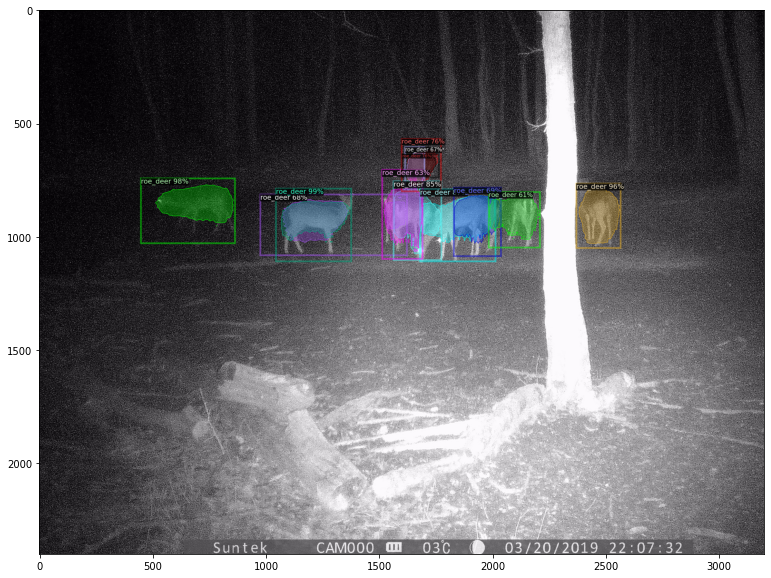

In [51]:
for d in random.sample(test_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=deer_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()